# Importing dependencies

The only dependecy we need is the awesome `python-chess` module. Besides that we import types from the `typing` module to help specify types of inputs and outputs to our functions

In [191]:
from typing import Tuple, List, Dict, Optional
from dataclasses import dataclass

import chess
import chess.pgn
from chess import piece_name, square_name, Color

import pandas as pd

# Tracking positions of the pieces during a game

In order to compute the lifetime of each piece, we want to be able to track the position of each piece during a game.

When a move is made, some pieces (at most two in case of castling) changes their positions. In addition to that, at most one piece can be captured in a single move which means that this piece's lifetime ends and it is removed from the board.

To track the changes in pieces positions after a single move, we introduce `get_move_squares` function that takes the current board and a move, and returns a tuple where the first element is a list of tuples (from, to) indicating pieces being moved from square to another square, and the second element is square where the captured piece was placed before the move. Notice that this capture square is not always the square one of the piece moved - this is not true in the case of an en passant move.

In [175]:
def get_move_squares(board, move) -> Tuple[List[Tuple[chess.Square, chess.Square]], Optional[chess.Square]]:
    """
    returns a tuple where the first element is a list of tuples (from, to) 
    indicating pieces being moved from square to square
    and the second element is the capture square, or None if there is no capture

    implementation inspired by:
    https://github.com/niklasf/python-chess/blob/855603cc30e090363fa070b2df76a09106cbe18c/chess/__init__.py#L2112
    """

    # Corrents the from_square and to_square attributes of a move
    # in case the move is a castling move
    move = board._to_chess960(move)
    
    from_sq = move.from_square
    to_sq = move.to_square
    to_sq_occupied = board.piece_type_at(to_sq) != None

    # Handle special pawn moves
    if board.piece_type_at(from_sq) == chess.PAWN:
        ep_square = board.ep_square
        diff = move.to_square - move.from_square

        if to_sq == ep_square and abs(diff) in [7, 9] and not to_sq_occupied:
            # Handle en passant move
            down = -8 if board.turn == chess.WHITE else 8
            cap_sq = ep_square + down
            return [(from_sq, to_sq)], cap_sq

    # Handle castling
    if board.is_castling(move):

        a_side = chess.square_file(move.to_square) < chess.square_file(move.from_square)

        # Queen-side castling
        if a_side:
            return [
                (from_sq, chess.C1 if board.turn == chess.WHITE else chess.C8),
                (to_sq, chess.D1 if board.turn == chess.WHITE else chess.D8),
            ], None

        # King-side castling
        return [
            (from_sq, chess.G1 if board.turn == chess.WHITE else chess.G8),
            (to_sq, chess.F1 if board.turn == chess.WHITE else chess.F8),
        ], None
        
    # Handle regular move
    return [(from_sq, to_sq)], to_sq if to_sq_occupied else None
    

# Testing `get_move_squares` function

A few very simple tests to test if our `get_move_squares` function works as expected.

In [176]:
def get_square_name(sq: Optional[chess.Square]) -> Optional[str]:
    return chess.square_name(sq) if sq else None

def test(moves):
    board = chess.Board()
    for uci in moves:
        move = chess.Move.from_uci(uci)
        move_squares, cap_square = get_move_squares(board, move)
        move_squares = [(get_square_name(a), get_square_name(b)) for a, b in move_squares]
        print(move_squares, get_square_name(cap_square))
        board.push(move)
        
moves_en_passant = ['e2e4', 'a7a6', 'e4e5', 'd7d5', 'e5d6']
moves_kingside_castling = ['e2e4', 'a7a6', 'g1f3', 'b7b6', 'f1e2', 'c7c6', 'e1g1']
moves_queenside_castling = ['d2d4', 'a7a6', 'b1c3', 'b7b6', 'c1e3', 'c7c6', 'd1d2', 'd7d6', 'e1c1']
moves_scandi = ['e2e4', 'd7d5', 'e4d5', 'd8d5']

print("testing with en passant")
test(moves_en_passant)
print("testing with kingside castling")
test(moves_kingside_castling)
print("testing with queenside castling")
test(moves_queenside_castling)
print("testing with scandinavian opening")
test(moves_scandi)


testing with en passant
[('e2', 'e4')] None
[('a7', 'a6')] None
[('e4', 'e5')] None
[('d7', 'd5')] None
[('e5', 'd6')] d5
testing with kingside castling
[('e2', 'e4')] None
[('a7', 'a6')] None
[('g1', 'f3')] None
[('b7', 'b6')] None
[('f1', 'e2')] None
[('c7', 'c6')] None
[('e1', 'g1'), ('h1', 'f1')] None
testing with queenside castling
[('d2', 'd4')] None
[('a7', 'a6')] None
[('b1', 'c3')] None
[('b7', 'b6')] None
[('c1', 'e3')] None
[('c7', 'c6')] None
[('d1', 'd2')] None
[('d7', 'd6')] None
[('e1', 'c1'), (None, 'd1')] None
testing with scandinavian opening
[('e2', 'e4')] None
[('d7', 'd5')] None
[('e4', 'd5')] d5
[('d8', 'd5')] d5


# Computing lifetime of pieces in a single game

Now, having the `get_move_squares` function defined, we want to use it to compute the lifetime of all the pieces during a single game.

We denote each piece by the square it is placed in the starting position of the game. By doing that, we can easily distinguish all the pieces during the game, including those occur more than once for each of the colors, i.e. pawns, knight, bishops and rooks.

We define a lifetime of a piece is the number of full moves it was alive, and a piece dies only when it is captured.

When a pawn promotes to a piece, no new piece is "born" after a pawn is promoted, instead, the pawn remains alive.

In order to track the positions of all the pieces, we maintain a mapping from a square a piece is placed in the current position of the game to its initial square (that uniquely identifies the piece). We update this mapping by using the `get_move_squares` function.


In [187]:
@dataclass
class Piece:
    init_square: int
    lifetime: int
    
    def get_unique_desc(self) -> Tuple[str, str, str]:
        return (chess.COLOR_NAMES[init_board.color_at(self.init_square)], 
                chess.piece_name(init_board.piece_type_at(self.init_square)),
                chess.square_name(self.init_square))
    

def get_lifetimes(game: chess.pgn.Game) -> Dict[chess.Square, int]:
    board = game.board()
    if board.fen() != chess.STARTING_FEN:
        raise ValueError("Game must start from the initial position")
    
    init_board = chess.Board(chess.STARTING_FEN)
    pieces = {sq: Piece(init_square=sq, lifetime=0) 
              for sq in chess.SQUARES if init_board.piece_at(sq)}
    captured_pieces = []
    
    for move in game.mainline_moves():
        
        move_sqs, cap_sq = get_move_squares(board, move)

        if cap_sq:
            # captured piece dies
            captured_piece = pieces[cap_sq]
            captured_piece.lifetime = board.fullmove_number
            captured_pieces.append(captured_piece)
            del pieces[cap_sq]
            

        for from_sq, to_sq in move_sqs:
            pieces[to_sq] = pieces[from_sq]
            del pieces[from_sq]

        board.push(move)
        
    # assign lifetimes of remaining alive pieces after the game ended
    lifetime = {p.get_unique_desc(): board.fullmove_number  for p in pieces.values() }
    lifetime.update({p.get_unique_desc(): p.lifetime for p in captured_pieces})
    return lifetime



# Computing the lifetime of pieces in all games from a PGN file

In [255]:
%%time 

pgn_filepath = "data/lichess_elite_2022-11.pgn" 
res = []

with open(pgn_filepath) as pgn_file:
    while game := chess.pgn.read_game(pgn_file):

        lifetimes = get_lifetimes(game)
        res.append({**lifetimes, 
                    "black_elo": game.headers["BlackElo"], 
                    "white_elo": game.headers["WhiteElo"]})

            


CPU times: user 11min 9s, sys: 2.27 s, total: 11min 11s
Wall time: 11min 12s


# Combining data from all the games

We calculate mean lifetime value for each of the pieces as our estimator of piece lifetime expectancy.

In [256]:
res_df = pd.DataFrame.from_dict(res)
means = res_df\
        .drop("black_elo", axis="columns")\
        .drop("white_elo", axis="columns")\
        .mean().sort_values(ascending=False)

## Numerical results

Let's print our data in numerical format first.

In [257]:
means

(black, king, e8)      45.183374
(white, king, e1)      45.183374
(white, pawn, h2)      37.300290
(black, pawn, h7)      37.148264
(white, pawn, g2)      36.414448
(black, pawn, g7)      36.083859
(white, pawn, a2)      34.897495
(white, pawn, f2)      34.893324
(black, pawn, a7)      34.880167
(black, pawn, f7)      34.485464
(black, rook, h8)      33.210915
(black, rook, a8)      33.160522
(white, rook, a1)      33.130007
(white, rook, h1)      33.083489
(white, pawn, b2)      32.733628
(black, pawn, b7)      32.311241
(black, queen, d8)     28.328667
(white, queen, d1)     28.147307
(black, pawn, e7)      27.650204
(white, pawn, c2)      26.088743
(black, bishop, f8)    25.855677
(white, bishop, f1)    25.454252
(black, bishop, c8)    25.237251
(white, bishop, c1)    24.579132
(white, pawn, e2)      24.129999
(black, pawn, c7)      24.027787
(black, knight, b8)    23.343073
(white, knight, b1)    22.471911
(black, knight, g8)    22.346036
(white, knight, g1)    22.244596
(black, pa

# Plotting

For plotting we use `matplotlib` so you should have it installed if you want to get a nice plot along the numerical data.

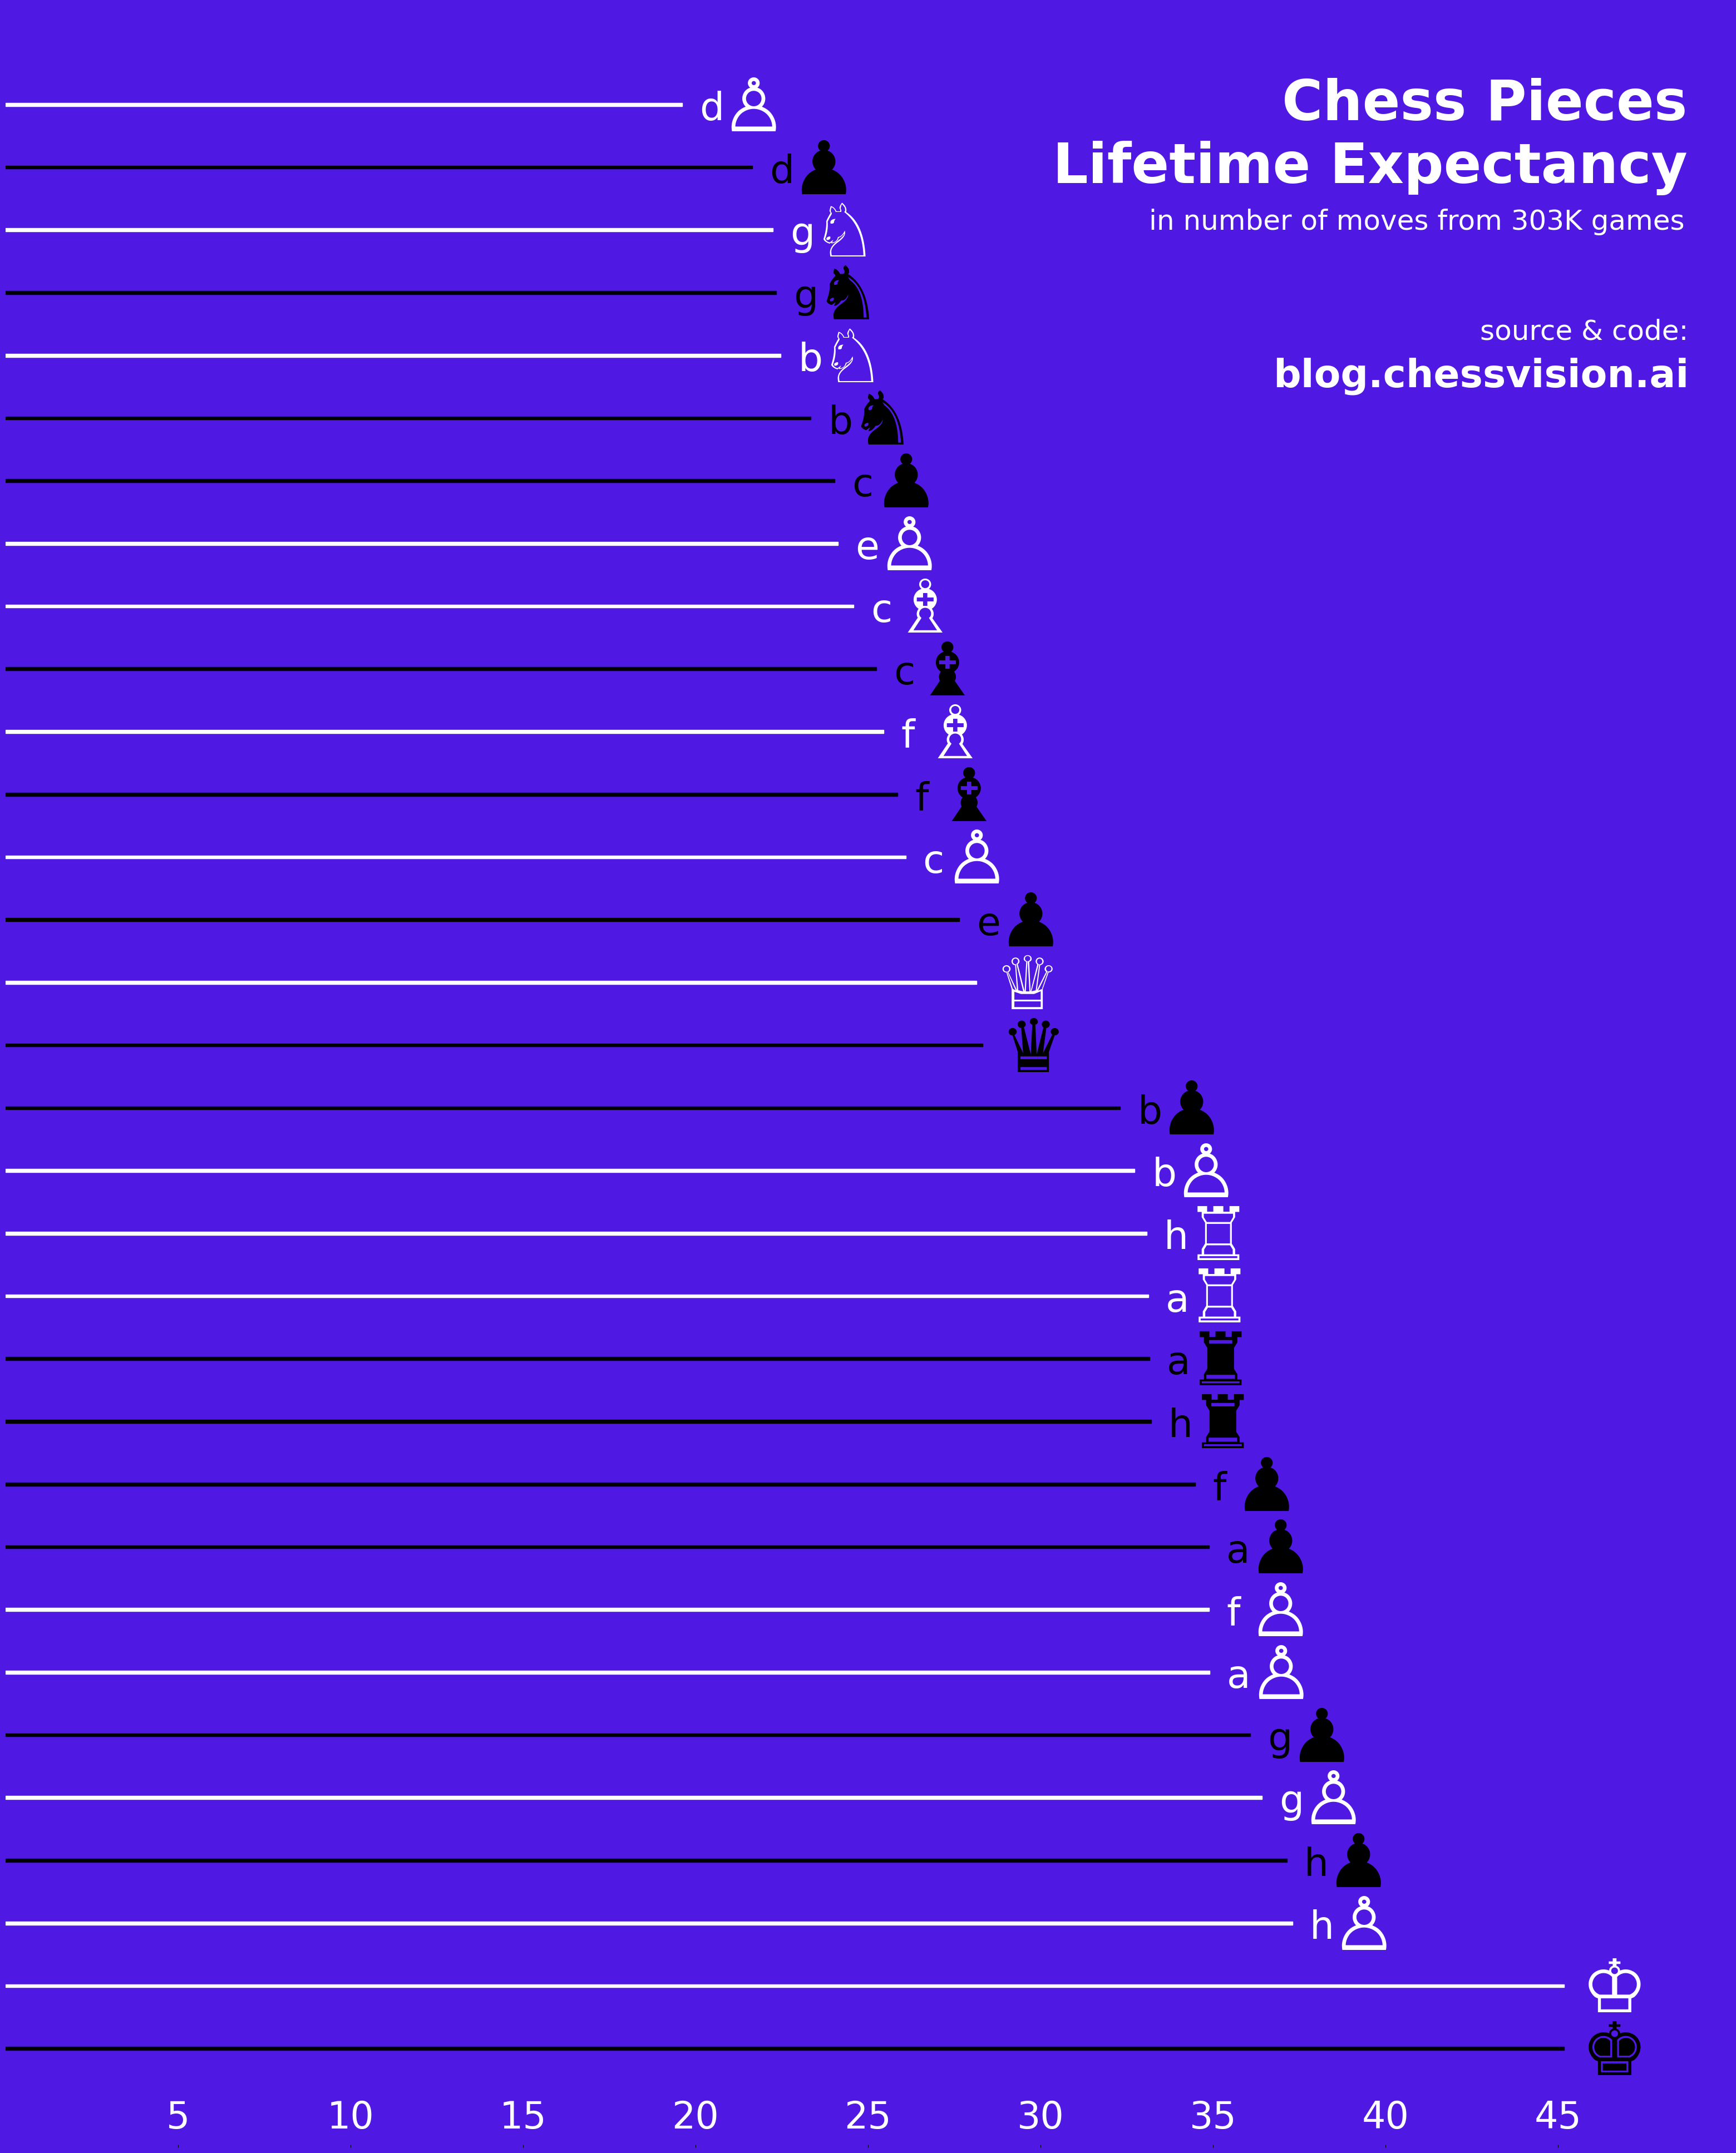

In [258]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = ['DejaVu Sans']

fig, ax = plt.subplots(figsize=(40, 50))   
ax.set_frame_on(False) 
fig.set_facecolor('#4F19E3')
ax.grid(False)
ax.set_facecolor('#4F19E3')
names = ["_".join(name) for name in means.index]
values = [val for val in means]
barlist = plt.barh(names, values, height=0.05)
for i, bar in enumerate(barlist):
    color, piece, square = names[i].split("_")
    bar.set_color(color)
    
def piece_to_symbol(color, piece):
    name_offset = ["king", "queen", "rook", "bishop", "knight", "pawn"]
    color_offset = {"white": 0, "black": 6}
    return chr(9812 + name_offset.index(piece) + color_offset[color])

for i, v in enumerate(values):
    color, piece, square = names[i].split("_")
    h_offset = 0.5
    if piece not in ["king", "queen"]:
        file = square[0]
        ax.text(v + h_offset, i - .25, str(file), color=color, fontsize=50, fontweight='normal')
        h_offset += 0.6
    text = piece_to_symbol(color, piece)
    
    # we should use font that supports chess pieces in UTF-8
    # here, we use FreeSerif medium which has very nice pieces
    # if you don't have it available on your system you can either download it
    # or replace the fontfamily parameter in the below line with e.g. "DejaVu Sans"
    ax.text(v + h_offset, i - .425, text, color=color, fontfamily='DejaVu Sans', fontsize=96, fontweight='medium')
    
ax.text(37, 30.75, "Chess Pieces", color='white', fontsize=72, fontweight='bold')
ax.text(30.35, 29.75, "Lifetime Expectancy", color='white', fontsize=72, fontweight='bold')
ax.text(33.15, 29, "in number of moves from %dK games" % (len(res) // 1000), color='white', fontsize=36, fontweight='normal')
ax.text(42.75, 27.25, "source & code:", color='white', fontsize=36, fontweight='normal')
ax.text(36.75, 26.5, "blog.chessvision.ai", color='white', fontsize=50, fontweight='bold')
ax.set_yticks([])
ax.set_xticks([5, 10, 15, 20, 25, 30, 35, 40, 45])
ax.tick_params(axis="x", direction="in", pad=-62)

plt.xlim(0, 50)
plt.xticks(fontsize=48, color='white', fontweight='normal')
plt.show()
#fig.savefig('plot.png', dpi=fig.dpi, facecolor=fig.get_facecolor(), edgecolor='none', bbox_inches='tight')